In [7]:
import numpy as np
import scipy.stats as stats

In [87]:
# Seed data

N = 21
r = np.array([10, 23, 23, 26, 17, 5, 53, 55, 32, 46, 10, 8, 10, 8, 23, 0, 3, 22, 15, 32, 3])
n = np.array([39, 62, 81, 51, 39, 6, 74, 72, 51, 79, 13, 16, 30, 28, 45, 4, 12, 41, 30, 51, 7])
x_1 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
x_2 = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])


# Seed Init
alpha_0 = 0
alpha_1 = 0
alpha_2 = 0
alpha_12 = 0
tau = 10
b = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0]


In [86]:
####Rien a voir tentative de faire le même modele que celui sur R
def sigmoid(x):
    return 1/(1+np.exp(-x))


def model(r, x1, x2, n, n_iter=2000, burn_in=1000):
    ###Initialisation
    N = len(r)
    alpha0 = 0
    alpha1 = 0
    alpha2 = 0
    alpha12 = 0
    tau = 10
    sigma=1/tau
    b = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0]

    p = np.zeros(N)
    
    for i in range(N):
        p[i] = np.random.binomial(n=n[i], p=0.5)        # Echantillonage

        
    # Boucle principale
    for j in range(n_iter):
        b = np.random.normal(loc=0.0, scale=sigma, size=N)        # Echantillonnage des erreurs aléatoires

        for i in range(N):
            w = alpha0 + alpha1 * x1[i] + alpha2 * x2[i] + alpha12 * x1[i] * x2[i] + b[i]
            p[i] = np.random.binomial(n=n[i], p=sigmoid(w))

        alpha0 = np.random.normal(loc=np.mean(p - alpha1 * x1 - alpha2 * x2 - alpha12 * x1 * x2 - b),
                                scale=sigma / np.sqrt(N))
        alpha1 = np.random.normal(loc=np.mean((p - alpha0 - alpha2 * x2 - alpha12 * x1 * x2) * x1),
                                scale=sigma / np.sqrt(np.sum(x1 ** 2)))
        alpha2 = np.random.normal(loc=np.mean((p - alpha0 - alpha1 * x1 - alpha12 * x1 * x2) * x2),
                                scale=sigma / np.sqrt(np.sum(x2 ** 2)))
        alpha12 = np.random.normal(loc=np.mean((p - alpha0 - alpha1 * x1 - alpha2 * x2) * x1 * x2),
                                 scale=sigma / np.sqrt(np.sum(x1 ** 2 * x2 ** 2)))
        tau = np.random.gamma.rvs(a=0.001 + N / 2, scale=1 / (0.001 + np.sum(b ** 2) / 2))
        sigma = 1 / np.sqrt(tau)

    alpha0_samples = np.zeros(n_iter - burn_in)
    alpha1_samples = np.zeros(n_iter - burn_in)
    alpha2_samples = np.zeros(n_iter - burn_in)
    alpha12_samples = np.zeros(n_iter - burn_in)
    tau_samples = np.zeros(n_iter - burn_in)
    for i in range(burn_in, n_iter):
        b = np.random.normal(loc=0.0, scale=sigma, size=N)
        for j in range(N):
            w = alpha0 + alpha1 * x1[j] + alpha2 * x2[j] + alpha12 * x1[j] * x2[j] + b[j]
            p[j] = np.random.binomial(n=n[j], p=sigmoid(w))

        alpha0_samples[i - burn_in] = alpha0
        alpha1_samples[i - burn_in] = alpha1
        alpha2_samples[i - burn_in] = alpha2
        alpha12_samples[i - burn_in] = alpha12
        tau_samples[i - burn_in] = tau

    return {'alpha0': alpha0_samples, 'alpha1': alpha1_samples, 'alpha2': alpha2_samples,
        'alpha12': alpha12_samples, 'tau': tau_samples}

In [73]:
model(r, x_1, x_2, n, n_iter=2000, burn_in=1000)

AttributeError: 'builtin_function_or_method' object has no attribute 'rvs'

In [34]:
x1.shape

(21,)

## Tentative de metropolis hastings

Défini une fonction log_posterior qui calcule la probabilité log-posterior pour le modèle. Cette fonction prend en entrée les valeurs des paramètres alpha0, alpha1, alpha2, alpha12, tau, ainsi que les données r, n, x1, x2 et N. La fonction tire d'abord un échantillon de b d'une distribution normale de moyenne 0 et d'écart-type sqrt(tau),calcule ensuite la probabilité p de succès pour chaque observation, sur la base du modèle de régression logistique , ensuite on calcule la log-vraisemblance et la log-priorité, et je renvoie leur somme, qui est la probabilité log-postérieure




In [9]:
def log_posterior(alpha0, alpha1, alpha2, alpha12, tau, r, n, x1, x2, N):
    b = np.random.normal(0.0, np.sqrt(tau), N)
    p = np.zeros(N)
    for i in range(N):
        p[i] = np.exp(alpha0 + alpha1 * x1[i] + alpha2 * x2[i] +
                      alpha12 * x1[i] * x2[i] + b[i]) / (1 + np.exp(alpha0 + alpha1 * x1[i] + alpha2 * x2[i] +
                      alpha12 * x1[i] * x2[i] + b[i]))
    log_likelihood = np.sum(np.log(p) * r + np.log(1 - p) * (n - r))
    log_prior = -0.5 * np.log(tau) - 0.5 * tau
    return log_likelihood + log_prior

Fonction pour metropolis hastings

In [10]:
def metropolis_hastings(initial_values, iterations, proposal_sd, r, n, x1, x2, N):
    # Initialisation
    alpha0, alpha1, alpha2, alpha12, tau = initial_values
    accepted_values = np.zeros((iterations, 5))
    
    for i in range(iterations):
        # Propose une nouvelle valeur avec la loi normale
        proposed_values = np.random.normal([alpha0, alpha1, alpha2, alpha12, tau], proposal_sd)
        
        # Calcul la proba d'acpetation
        log_acceptance_ratio = log_posterior(proposed_values[0], proposed_values[1], proposed_values[2],proposed_values[3], proposed_values[4], r, n, x1, x2, N) - log_posterior(alpha0, alpha1, alpha2, alpha12, tau, r, n, x1, x2, N)
        
        #
        u = np.log(np.random.uniform())
        
        # Test pour accepte la proposition
        if u < log_acceptance_ratio:
            alpha0, alpha1, alpha2, alpha12, tau = proposed_values
            accepted_values[i,:] = proposed_values
        else:
            accepted_values[i,:] = [alpha0, alpha1, alpha2, alpha12, tau]
    
    return accepted_values


In [27]:
init = [alpha_0,alpha_1, alpha_2, alpha_12,tau]
iterations = 1000
proposal_sd = [0.1, 0.1, 0.1, 0.1, 0.1]

accepted_values = metropolis_hastings(init, iterations, proposal_sd, r, n, x_1, x_2, N)
accepted_values = np.column_stack((accepted_values, 1/accepted_values[:, 4]))

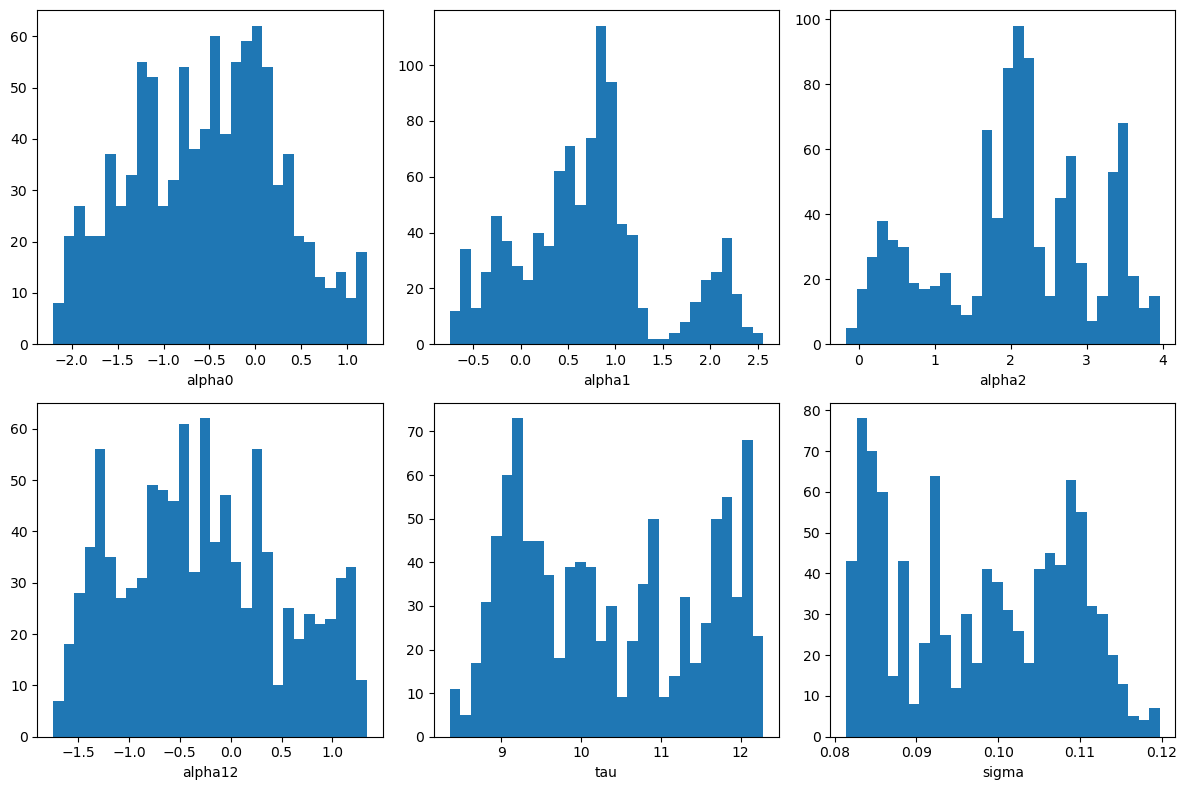

In [28]:
import matplotlib.pyplot as plt

#Distribution des paramètres
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs[0, 0].hist(accepted_values[:, 0], bins=30)
axs[0, 0].set_xlabel('alpha0')
axs[0, 1].hist(accepted_values[:, 1], bins=30)
axs[0, 1].set_xlabel('alpha1')
axs[0, 2].hist(accepted_values[:, 2], bins=30)
axs[0, 2].set_xlabel('alpha2')
axs[1, 0].hist(accepted_values[:, 3], bins=30)
axs[1, 0].set_xlabel('alpha12')
axs[1, 1].hist(accepted_values[:, 4], bins=30)
axs[1, 1].set_xlabel('tau')
axs[1, 2].hist(accepted_values[:, 5], bins=30)
axs[1, 2].set_xlabel('sigma')
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd

# Calculate summary statistics
result = pd.DataFrame({'mean': accepted_values.mean(axis=0),'sd': accepted_values.std(axis=0),'mc_error':np.std(accepted_values, axis=0) / np.sqrt(len(accepted_values)),'val2.5pc':np.percentile(accepted_values, 2.5, axis=0),'median': np.median(accepted_values,axis=0),'val97.5pc': np.percentile(accepted_values, 97.5, axis=0)},index=['alpha0', 'alpha1', 'alpha2', 'alpha12', 'tau','sigma'])

print(result)

              mean        sd  mc_error  val2.5pc     median  val97.5pc
alpha0   -0.260701  0.722530  0.022848 -1.788521  -0.181783   0.798039
alpha1    0.073485  0.600173  0.018979 -0.875731   0.031870   1.115910
alpha2    2.400240  1.310109  0.041429 -0.342069   2.788126   4.235479
alpha12   0.415849  0.326117  0.010313 -0.202307   0.447995   1.049114
tau      10.061716  0.487029  0.015401  8.974682  10.117581  10.852216
sigma     0.099626  0.004960  0.000157  0.092147   0.098838   0.111425


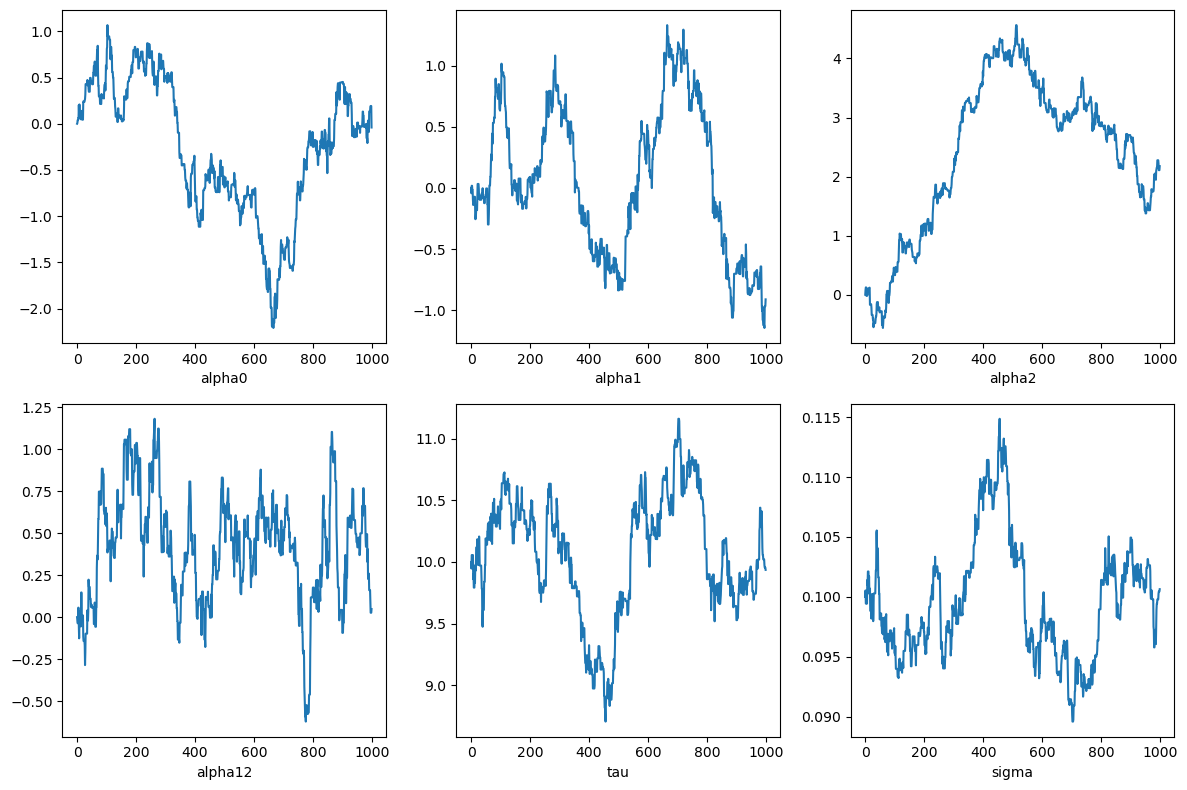

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs[0, 0].plot(accepted_values[:, 0])
axs[0, 0].set_xlabel('alpha0')
axs[0, 1].plot(accepted_values[:, 1])
axs[0, 1].set_xlabel('alpha1')
axs[0, 2].plot(accepted_values[:, 2])
axs[0, 2].set_xlabel('alpha2')
axs[1, 0].plot(accepted_values[:, 3])
axs[1, 0].set_xlabel('alpha12')
axs[1, 1].plot(accepted_values[:, 4])
axs[1, 1].set_xlabel('tau')
axs[1, 2].plot(accepted_values[:, 5])
axs[1, 2].set_xlabel('sigma')
plt.tight_layout()
plt.show()

Pas bon du tout 

# Recommence Gibbs+MH de zero comme pas de solution

In [29]:
def log_posterior1(alpha0, alpha1, alpha2, alpha12, tau, r, n, x1, x2, N,b):
    p = np.zeros(N)
    for i in range(N):
        p[i] = np.exp(alpha0 + alpha1 * x1[i] + alpha2 * x2[i] +
                      alpha12 * x1[i] * x2[i] + b[i]) / (1 + np.exp(alpha0 + alpha1 * x1[i] + alpha2 * x2[i] +
                      alpha12 * x1[i] * x2[i] + b[i]))
    log_likelihood = np.sum(np.log(p) * r + np.log(1 - p) * (n - r))
    log_prior = -0.5 * np.log(tau) - 0.5 * tau
    return log_likelihood + log_prior

In [120]:
def gibbs(n_iterations,burnin,prop_sd,sd_b,param_init,I,x1,x2,r,n):
    #initailisation
    chain=np.zeros((n_iterations+1,5))
    b = np.zeros((n_iterations+1,I))
    acc_rates = np.zeros(5)
    # init premiere valeur
    chain[0,0] = param_init[0]
    chain[0,1] = param_init[1]
    chain[0,2] = param_init[2]
    chain[0,3] = param_init[3]
    chain[0,4] = param_init[4]
    b[0]=param_init[5]


    
    for i in range(1,n_iterations):
        alpha0, alpha1,alpha2,alpha12,sigma = chain[i,:]
        bi=b[i]
        tau=1/sigma
        # Maj b
        for j in range(I):
            prop=np.random.normal(b[i][j], sd_b, size = 1)
            
            top=(-prop**2)/(2*(1/sigma))+r[j]*np.log(1 / (1 + np.exp(alpha0 + alpha1 * x1[j] + alpha2 * x2[j] +alpha12 * x1[j] * x2[j] +prop)))+(n[j]-r[j])*np.log(1-(1 / (1 + np.exp(alpha0 + alpha1 * x1[j] + alpha2 * x2[j] +alpha12 * x1[j] * x2[j] +prop))))
            
            bottom=(-b[i][j]**2)/(2*(1/sigma))+r[j]*np.log(1 / (1 + np.exp(alpha0 + alpha1 * x1[j] + alpha2 * x2[j] +alpha12 * x1[j] * x2[j] +b[i][j])))+(n[j]-r[j])*np.log(1-(1 / (1 + np.exp(alpha0 + alpha1 * x1[j] + alpha2 * x2[j] +alpha12 * x1[j] * x2[j] +b[i][j]))))
            
            acc_proba=np.exp(top-bottom)
            
            if np.random.uniform() < acc_proba:
                b[i][j]=prop
                acc_rates[4]+=1
            b[j+1]=b[j]

           
        
        #Maj alpha0
        prop = np.random.normal(alpha0, prop_sd[0], size = 1)
        
        top=log_posterior1(prop, alpha1, alpha2, alpha12, tau, r, n, x1, x2, I,bi)
        
        bottom=log_posterior1(alpha0, alpha1, alpha2, alpha12, tau, r, n, x1, x2, I,bi)
        
        acc_proba=np.exp(top-bottom)
        
        if np.random.uniform() < acc_proba:
            alpha0=prop
            acc_rates[0]+=1
       
        #Maj alpha1
        prop = np.random.normal(alpha1, prop_sd[1], size = 1)
        
        top=log_posterior1(alpha0, prop, alpha2, alpha12, tau, r, n, x1, x2, I,bi)
        
        bottom=log_posterior1(alpha0, alpha1, alpha2, alpha12, tau, r, n, x1, x2, I,bi)
        
        acc_proba=np.exp(top-bottom)
        
        if np.random.uniform() < acc_proba:
            alpha1=prop
            acc_rates[1]+=1
        
        #Maj alpha2
        prop = np.random.normal(alpha2, prop_sd[2], size = 1)
        
        top=log_posterior1(alpha0, alpha1, prop, alpha12, tau, r, n, x1, x2, I,bi)
        
        bottom=log_posterior1(alpha0, alpha1, alpha2, alpha12, tau, r, n, x1, x2, I,bi)
        
        acc_proba=np.exp(top-bottom)
        
        if np.random.uniform() < acc_proba:
            alpha2=prop
            acc_rates[2]+=1
        
        #Maj alpha12
        prop = np.random.normal(alpha12, prop_sd[3], size = 1)
        
        top=log_posterior1(alpha0, alpha1, alpha2, prop, tau, r, n, x1, x2, I,bi)
        
        bottom=log_posterior1(alpha0, alpha1, alpha2, alpha12, tau, r, n, x1, x2, I,bi)
        
        acc_proba=np.exp(top-bottom)
        
        if np.random.uniform() < acc_proba:
            alpha12=prop
            acc_rates[3]+=1
            
        ##Maj tau/sigma
        ###A voir selon si ca bouge dans le overleaf
        ###Vu que grand parent de pi je sais pas si faut faire  prop/top/bottom
        tau=np.random.gamma(0.001+I/2,1/(0.001+np.sum(bi**2)/2))
        sigma=1/np.sqrt(tau)
        
        chain[i+1,0] = alpha0
        chain[i+1,1] = alpha1
        chain[i+1,2] = alpha2
        chain[i+1,3] = alpha12
        chain[i+1,4] = sigma        
        
        print(i)
    ##Burnin
    chain=chain[burnin:]


    return chain,acc_rates    

In [121]:
init = [alpha_0,alpha_1, alpha_2, alpha_12,8,b]
gib=gibbs(10000, 1000, proposal_sd,0.01,init,N,x_1,x_2,r,n)

C:\Users\user\AppData\Local\Temp\ipykernel_16592\1269915753.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  tau=1/sigma
C:\Users\user\AppData\Local\Temp\ipykernel_16592\1269915753.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  top=(-prop**2)/(2*(1/sigma))+r[j]*np.log(1 / (1 + np.exp(alpha0 + alpha1 * x1[j] + alpha2 * x2[j] +alpha12 * x1[j] * x2[j] +prop)))+(n[j]-r[j])*np.log(1-(1 / (1 + np.exp(alpha0 + alpha1 * x1[j] + alpha2 * x2[j] +alpha12 * x1[j] * x2[j] +prop))))
C:\Users\user\AppData\Local\Temp\ipykernel_16592\1269915753.py:26: RuntimeWarning: divide by zero encountered in double_scalars
  bottom=(-b[i][j]**2)/(2*(1/sigma))+r[j]*np.log(1 / (1 + np.exp(alpha0 + alpha1 * x1[j] + alpha2 * x2[j] +alpha12 * x1[j] * x2[j] +b[i][j])))+(n[j]-r[j])*np.log(1-(1 / (1 + np.exp(alpha0 + alpha1 * x1[j] + alpha2 * x2[j] +alpha12 * x1[j] * x2[j] +b[i][j]))))
C:\Users\user\AppData\Local\Temp\ipykernel_16592\1269915753.py:44: RuntimeWarning: invalid val

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621


4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649


6380
6381
6382
6383
6384
6385
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464
6465
6466
6467
6468
6469
6470
6471
6472
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561
6562
6563
6564
6565
6566
6567
6568
6569
6570
6571
6572
6573
6574
6575
6576
6577
6578
6579


9971
9972
9973
9974
9975
9976
9977
9978
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989
9990
9991
9992
9993
9994
9995
9996
9997
9998
9999


In [122]:
gib

(array([[-0.54588259,  0.27673244,  1.2897547 , -0.83262604,  0.00882818],
        [-0.54588259,  0.32082961,  1.17550668, -0.85258652,  0.015932  ],
        [-0.62609956,  0.34305177,  1.17550668, -0.91430706,  0.01288435],
        ...,
        [-0.56640621, -0.0575356 ,  1.5505955 , -1.14067353,  0.0108818 ],
        [-0.53326723, -0.14856283,  1.5505955 , -1.08030174,  0.01478196],
        [-0.60247837, -0.12435356,  1.57589892, -1.05377711,  0.01842853]]),
 array([  6150.,   7577.,   7066.,   8190., 202129.]))

In [123]:
acc_rates=gib[1]
gib=gib[0]

In [124]:
import pandas as pd

# Calculate summary statistics
result = pd.DataFrame({'mean': gib.mean(axis=0),'sd': gib.std(axis=0),'mc_error':np.std(gib, axis=0) / np.sqrt(len(gib)),'val2.5pc':np.percentile(gib, 2.5, axis=0),'median': np.median(gib,axis=0),'val97.5pc': np.percentile(gib, 97.5, axis=0)},index=['alpha0', 'alpha1', 'alpha2', 'alpha12','sigma'])

print(result)

             mean        sd  mc_error  val2.5pc    median  val97.5pc
alpha0  -0.557701  0.119270  0.001257 -0.782521 -0.560556  -0.320528
alpha1   0.153230  0.224737  0.002369 -0.320124  0.169415   0.554826
alpha2   1.324808  0.173045  0.001824  0.975226  1.327631   1.660024
alpha12 -0.796047  0.307926  0.003246 -1.328378 -0.819363  -0.090342
sigma    0.014184  0.002540  0.000027  0.010110  0.013878   0.020072


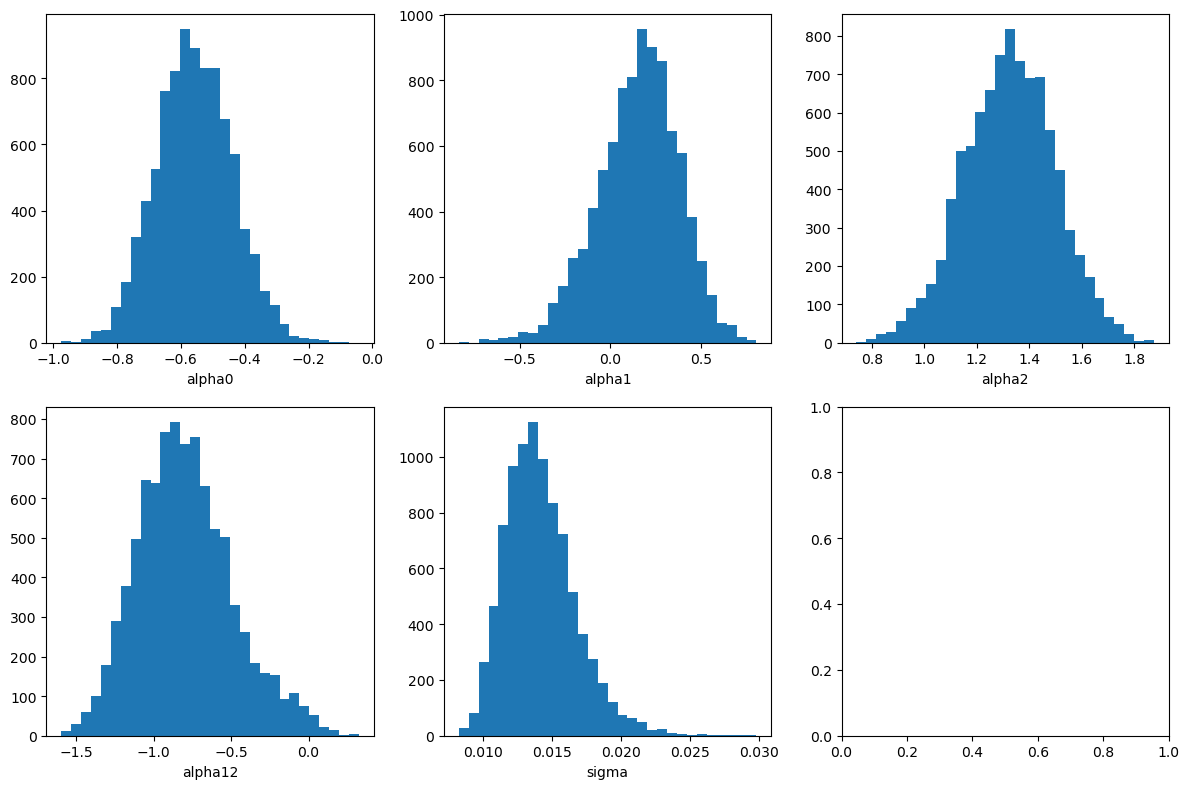

In [125]:
#Distribution des paramètres
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs[0, 0].hist(gib[:, 0], bins=30)
axs[0, 0].set_xlabel('alpha0')
axs[0, 1].hist(gib[:, 1], bins=30)
axs[0, 1].set_xlabel('alpha1')
axs[0, 2].hist(gib[:, 2], bins=30)
axs[0, 2].set_xlabel('alpha2')
axs[1, 0].hist(gib[:, 3], bins=30)
axs[1, 0].set_xlabel('alpha12')
axs[1, 1].hist(gib[:, 4], bins=30)
axs[1, 1].set_xlabel('sigma')
plt.tight_layout()
plt.show()

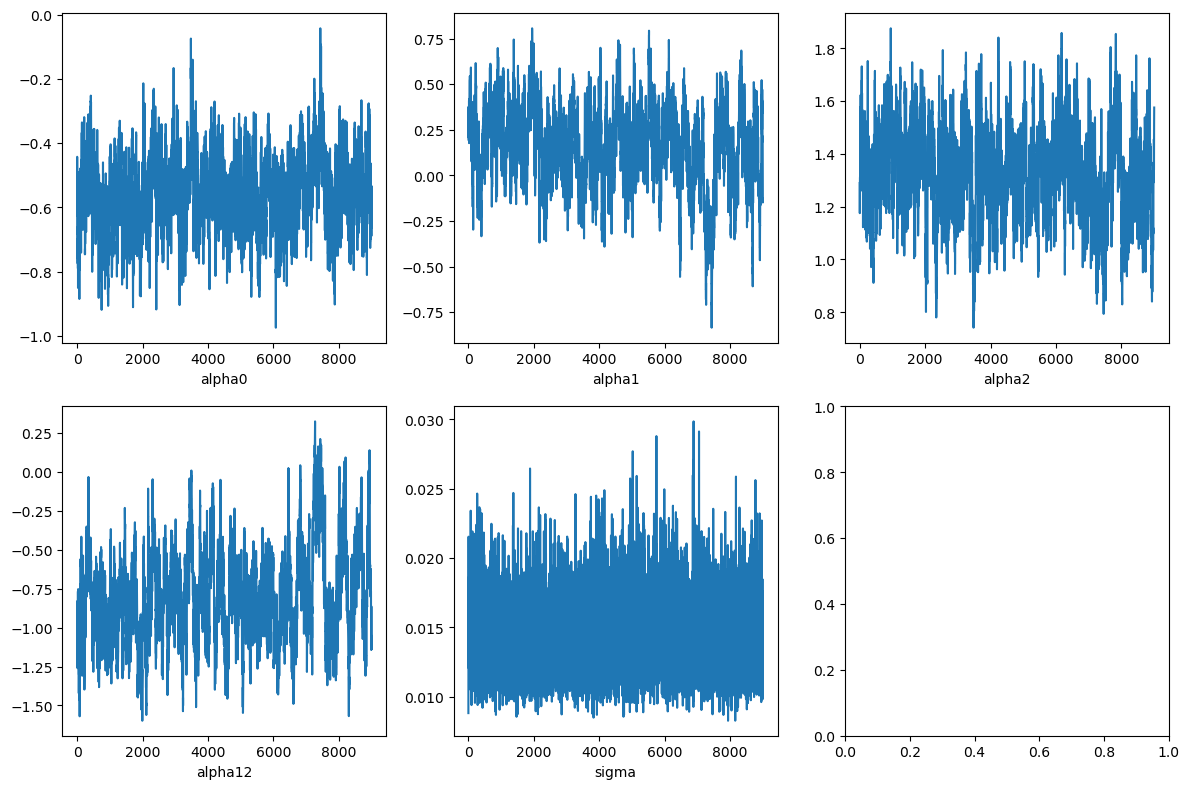

In [126]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs[0, 0].plot(gib[:, 0])
axs[0, 0].set_xlabel('alpha0')
axs[0, 1].plot(gib[:, 1])
axs[0, 1].set_xlabel('alpha1')
axs[0, 2].plot(gib[:, 2])
axs[0, 2].set_xlabel('alpha2')
axs[1, 0].plot(gib[:, 3])
axs[1, 0].set_xlabel('alpha12')
axs[1, 1].plot(gib[:, 4])
axs[1, 1].set_xlabel('sigma')
plt.tight_layout()
plt.show()